In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
import time

from proteus.matrix import registration
from nilearn.masking import compute_epi_mask
from proteus.visu import matrix as visu
from proteus.visu import montage


In [3]:
subj_id='SZ0040084'#HC0040123
# original subject from pierre exp
covar = pd.read_csv('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/resample/fmri_'+subj_id+'_session1_run1_n_confounds.tsv.gz',sep='\t')
covar.columns
vol_nii = nib.load('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/rest_'+subj_id+'.nii.gz')


vol = vol_nii.get_data()
Xmotion = covar.iloc[:,0:6].values
Xdrift  = covar.iloc[:,8:14].values
fd = covar['FD'].values

print vol.shape

(64, 64, 33, 150)


In [68]:
reload(registration)
cor_vols, aff_trans, motion_param = registration.coreg(vol_nii.get_data(), vol_nii.affine, ref='mean')

In [73]:
disp_field = registration.displacement_field(vol_nii.affine, motion_param, vol_nii.shape[:3])%3

In [28]:
cor_vols.shape

(64, 64, 33, 150)

In [27]:
mask_b = compute_epi_mask(vol_nii).get_data().astype(bool)

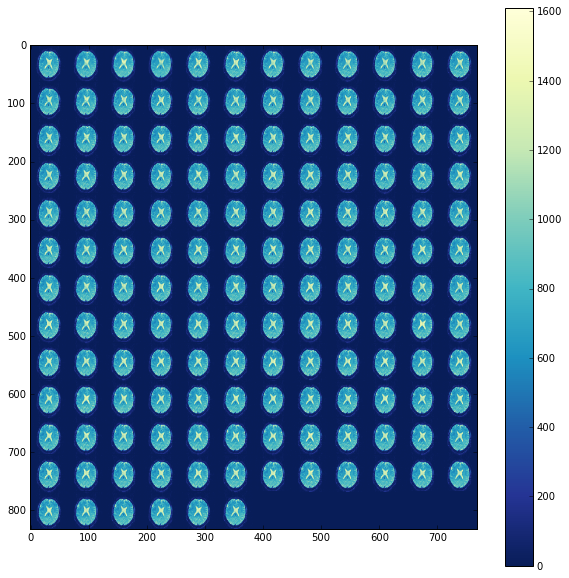

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(montage.transform(cor_vols[:,:,13,:]),cmap=plt.get_cmap('YlGnBu_r'))
plt.colorbar()

In [48]:
ref_signal = cor_vols[15:20,25:30,10:15,:].reshape((5*5*5,150)).mean(0)
ss=np.vstack([ref_signal,cor_vols[:,:,13,:][mask_b[:,:,13]]])
cor_val = np.corrcoef(ss)[0,1:]
cor_map = np.zeros_like(cor_vols[:,:,13,0])
cor_map[mask_b[:,:,13]] = cor_val

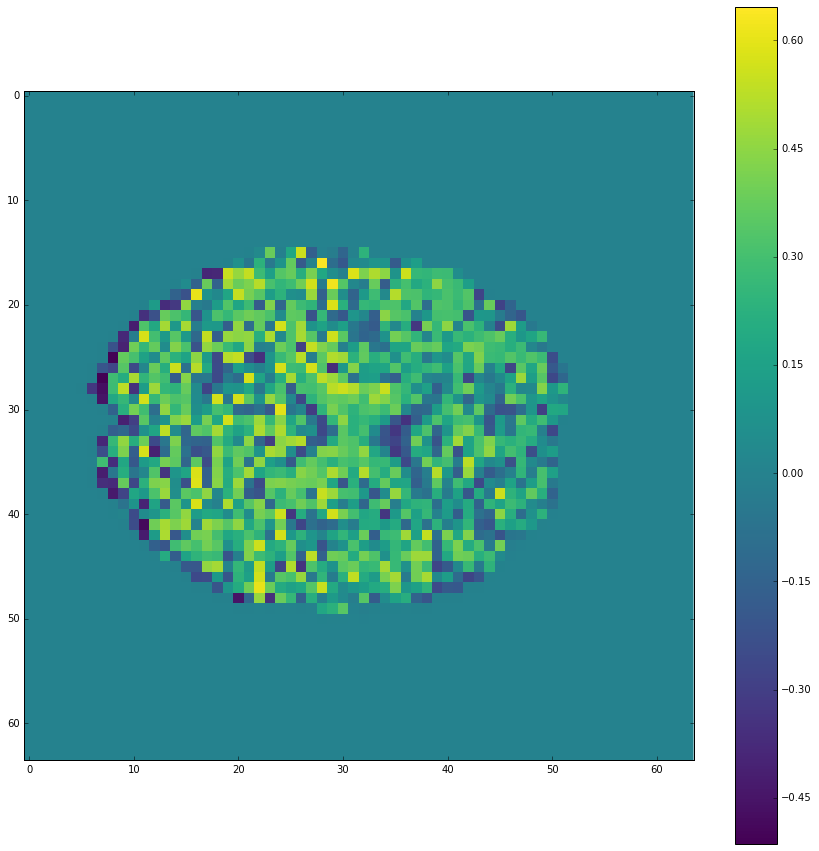

In [51]:
ref_signal = cor_vols[15:20,25:30,10:15,:].reshape((5*5*5,150)).mean(0)
ss=np.vstack([ref_signal,cor_vols[:,:,13,:][mask_b[:,:,13]]])
cor_val = np.corrcoef(ss)[0,1:]
cor_map = np.zeros_like(cor_vols[:,:,13,0])
cor_map[mask_b[:,:,13]] = cor_val

plt.figure(figsize=[15,15])
plt.imshow(cor_map,cmap=plt.cm.viridis,interpolation='none')
plt.colorbar()

In [20]:
deriv_motion = Xmotion[1:,...] - Xmotion[0:-1,...]

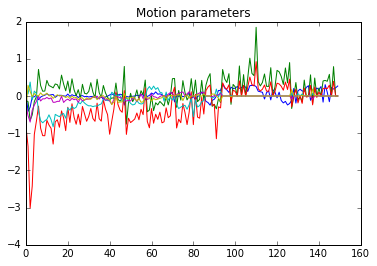

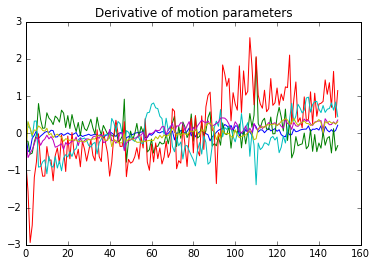

In [74]:
plt.figure()
plt.title('Motion parameters')
plt.plot(motion_param)
plt.figure()
plt.title('Derivative of motion parameters')
plt.plot(Xmotion)

In [85]:
cor_vols.shape[:-1]

(64, 64, 33)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, 64, 64, 32, 1) 0                                            
____________________________________________________________________________________________________
conv3d_102 (Conv3D)              (None, 64, 64, 32, 12 1152                                         
____________________________________________________________________________________________________
max_pooling3d_11 (MaxPooling3D)  (None, 32, 32, 16, 12 0                                            
____________________________________________________________________________________________________
input_23 (InputLayer)            (None, 64, 64, 32, 3) 0                                            
___________________________________________________________________________________________

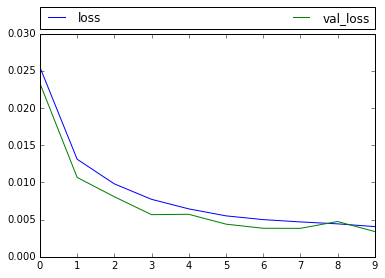

In [100]:

'''This script demonstrates how to build a variational autoencoder with Keras.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers.convolutional import Conv3D, UpSampling3D, MaxPooling3D
from keras.layers.core import RepeatVector,Reshape
#from keras.layers.core import SpatialDropout3D

from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
import keras
from keras import metrics
from keras.datasets import mnist
from keras.optimizers import RMSprop,Adagrad,Nadam




pred_vals = []
ref_vals = []

validation_split = 0.2
batch_size = 1
#original_dim = 64*64*batch_size#784
latent_dim = 256
#intermediate_dim = 256
epochs = 10
epsilon_std = 1.0

kdim=(2, 2, 2)
output_size = [64,64,32]
#latent_size = (22, 22, latent_dim) 

# motion
input_motion = Input(shape=(output_size[0], output_size[1], output_size[2], 3))  # adapt this if using `channels_first` image data format
xm = Conv3D(64, kdim, activation='relu', padding='same')(input_motion)
xm = Conv3D(64, kdim, activation='relu', padding='same')(xm)
x_motion = Conv3D(128, kdim, activation='relu', padding='same')(xm)
#x_motion = UpSampling2D((2, 2))(xm)

# frame to be corrected
input_img = Input(shape=(output_size[0], output_size[1], output_size[2], 1))  # adapt this if using `channels_first` image data format
x_inter1 = Conv3D(128, kdim, activation='relu', padding='same')(input_img)

#merge_motion_vol = keras.layers.add([x_motion,x])
x = MaxPooling3D((2, 2, 2), padding='same')(x_inter1)
x = Conv3D(256, kdim, activation='relu', padding='same')(x)
x = Conv3D(256, kdim, activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv3D(128, kdim, activation='relu', padding='same')(x)
encoded = UpSampling3D((2, 2, 2))(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

'''
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
z_mean = Conv2D(latent_dim, (1, 1), activation='relu', padding='same')(encoded)
z_log_var = Conv2D(latent_dim, (1, 1), activation='relu', padding='same')(encoded)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_size[0], latent_size[1], latent_size[2]), mean=0.,
                              stddev=epsilon_std)
    
    #print epsilon, z_mean
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=latent_size)([z_mean, z_log_var])
'''
# we instantiate these layers separately so as to reuse them later

merge_motion_embeding = keras.layers.multiply([x_motion,encoded])

decoder_h = Conv3D(512, (1, 1, 1), activation='relu', padding='same')(merge_motion_embeding)

#decoder_h = UpSampling2D((2, 2))(decoder_h)
decoder_h = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(decoder_h)
#decoder_h = UpSampling2D((2, 2))(decoder_h)
decoder_h = Conv3D(128, (2, 2, 2), activation='relu', padding='same')(decoder_h)

#decoder_h = MaxPooling2D((2, 2), padding='same')(decoder_h)


decoder_h = Conv3D(64, (1, 1, 1), activation='relu', padding='same')(decoder_h)
#merge1 = keras.layers.add([decoder_h,branch1])
#decoder_h = UpSampling2D((2, 2))(decoder_h)
h_decoded = Conv3D(32, (1, 1, 1), activation='relu', padding='same')(decoder_h)
#h_decoded = Conv2D(32, kdim, activation='relu', padding='same')(h_decoded)
x_decoded_mean = Conv3D(1, (1, 1, 1), activation='linear', padding='same')(h_decoded)
#decoder_mean = Dense(original_dim, activation='sigmoid')
#h_decoded = decoder_h(z)
#x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = metrics.MSE(x, x_decoded_mean)
    return xent_loss

vae = Model([input_img,input_motion], x_decoded_mean)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.2, nesterov=False)
rmsprop = RMSprop(lr=0.00005, rho=0.9, epsilon=1e-08, decay=0.0)
vae.compile(optimizer=rmsprop, loss=vae_loss)

vae.summary()

motion_field = disp_field[:-50,:,:,:32,:].copy()
#y_augm = lr_vols_motion_cor[:-100,:,:,5,np.newaxis].copy()/100.
y_augm = np.swapaxes(cor_vols[None,...],0,-1)[:-50,:,:,:32,0,np.newaxis]/1000
y_target = y_augm
#y_target = lr_vols[:-100,:,:,5,np.newaxis].copy()/100.

hist = vae.fit([y_augm,motion_field], y_target,verbose=1, epochs=epochs, batch_size=batch_size,validation_split=validation_split, shuffle=True)

plt.figure()
if validation_split == 0.:
    plt.plot(range(epochs),hist.history['loss'])
else:
    plt.plot(range(epochs),hist.history['loss'],range(epochs),hist.history['val_loss'])
plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)



## Test on independent data
#test_data = vae.predict([y_augm,motion_field],batch_size=1)
#pred_vals.append(test_data)
#ref_vals.append(y_target)


In [93]:
test_target = np.swapaxes(cor_vols[None,...],0,-1)[-50:,:,:,:32,0,np.newaxis]/1000
test_motion = disp_field[-50:,:,:,:32,:].copy()
test_data = vae.predict([test_target,test_motion],batch_size=1)
test_data_zerom = vae.predict([test_target,np.zeros_like(test_motion)],batch_size=1)

(100, 64, 64, 32)

In [101]:

#test_data = vae.predict([lr_vols_motion_cor[-100:,:,:,5,np.newaxis].copy()/100.,test_motion],batch_size=1)
def corrmap(image1,image2):
    cor_map = np.zeros((image1.shape[1],image1.shape[2]))
    for ii in range(image1.shape[1]):
        for jj in range(image1.shape[2]):
            cor_map[ii,jj] = np.corrcoef(image1[:,ii,jj],image2[:,ii,jj])[0,1]
    return cor_map


#cor_map_ref = np.nan_to_num(corrmap(test_target[...,0],test_target[...,0]))
#cor_map_lin = np.nan_to_num(corrmap(test_target[...,0],lr_vols_motion_cor[-100:,...,5]/100))
#cor_map_lin_deep = np.nan_to_num(corrmap(lr_vols_motion_cor[-100:,...,5]/100,test_data[...,0]))
#cor_map_deep = np.nan_to_num(corrmap(test_target[...,0],test_data[...,0]))

cor_map_zerom = np.nan_to_num(corrmap(test_target[...,0],test_data_zerom[...,0]))


In [103]:
print 'cor_map_zerom:',cor_map_zerom[cor_map_ref!=0].mean(),cor_map_zerom[cor_map_ref!=0].std()



 cor_map_zerom:

NameError: name 'cor_map_ref' is not defined

NameError: name 'cor_map_lin' is not defined

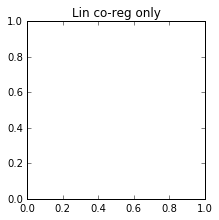

In [106]:
plt.figure(figsize=(7,7))
#plt.subplot(221)
#plt.title('Expected correlation')
#plt.imshow(np.nan_to_num(cor_map_ref),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
#plt.colorbar()
plt.subplot(222)
plt.title('Lin co-reg only')
plt.imshow(np.nan_to_num(cor_map_lin),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()
plt.subplot(223)
plt.title('Lin co-reg + deepmodel')
plt.imshow(np.nan_to_num(cor_map_deep),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

plt.subplot(224)
plt.title('Lin co-reg + zero motion')
plt.imshow(np.nan_to_num(cor_map_zerom),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

Atlas ROIs are located at: /home/cdansereau/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


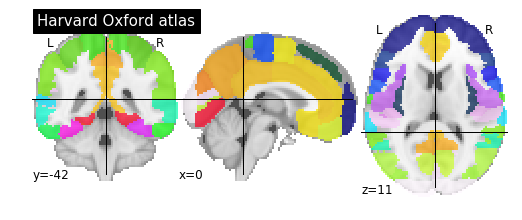

In [125]:


dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps

print('Atlas ROIs are located at: %s' % atlas_filename)

plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")
plotting.show()

(64, 64, 33)


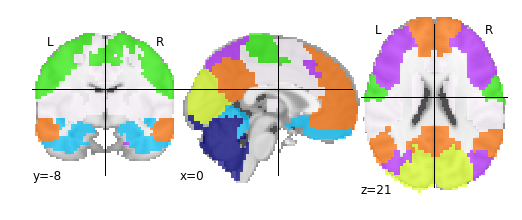

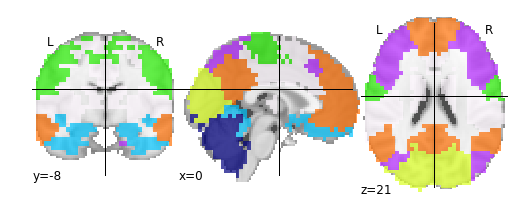

In [201]:
camb_template = nib.load('/media/cdansereau/database1/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz')
camb_template.get_data().shape

plotting.plot_roi(camb_template)

from nilearn import image
ss=image.resample_to_img(camb_template,vol_nii,interpolation='nearest')
print ss.shape
plotting.plot_roi(ss)


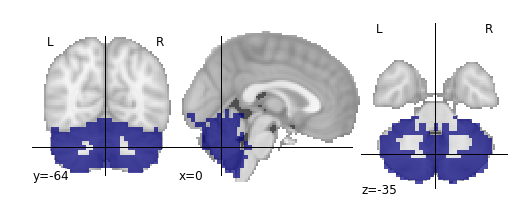

In [212]:
mask_seed.astype(int).shape
ss.affine

array([[   3.75      ,    0.        ,    0.        , -116.25      ],
       [  -0.        ,    3.35014272,   -2.04440165,  -63.72232056],
       [  -0.        ,    1.6849463 ,    4.06483984,  -97.02983093],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [193]:
from proteus.predic import prediction
reload(prediction)



In [ ]:
X = Xmotion
y = vol[mask_b].T

lreg_drift = LinearRegression(fit_intercept=True)
lreg_drift.fit(Xdrift[-50:,:],y)
new_y = y-lreg_drift.predict(Xdrift[-50:,:])


In [228]:
(np.swapaxes(cor_vols[None,...],0,-1)[:,:,:,:32,0,np.newaxis]/1000).shape

(150, 64, 64, 32, 1)

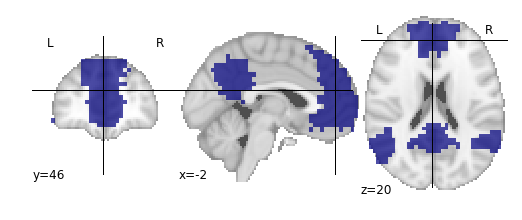

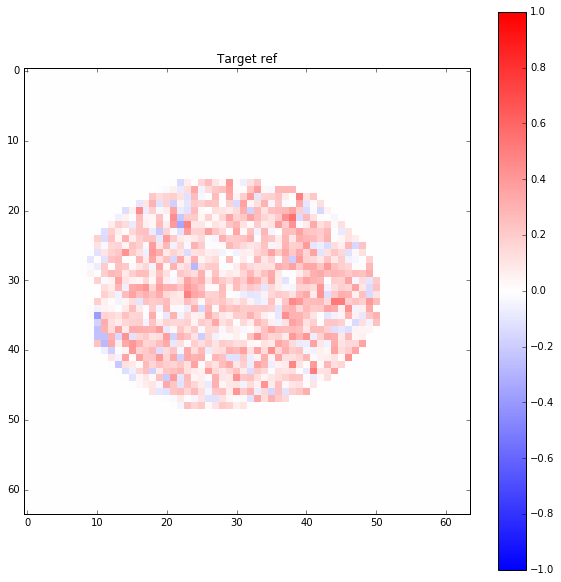

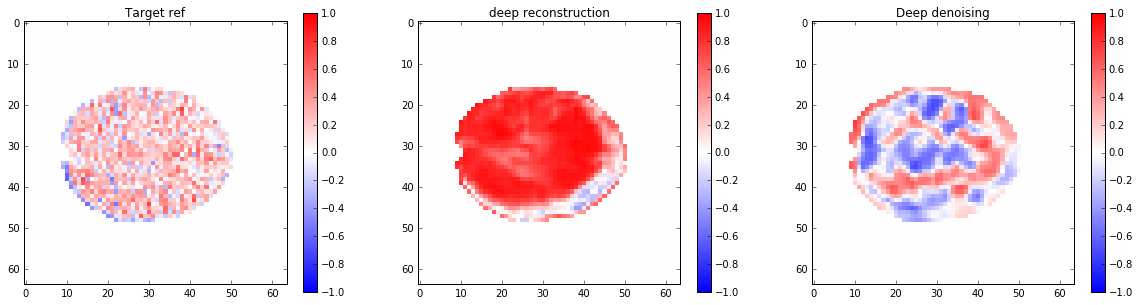

In [230]:
def compute_metric_corr(dat_tmp, cut=16):
    dat_tmp = np.swapaxes(dat_tmp[...,np.newaxis],0,-1)[0,...]

    ref_signal = dat_tmp[mask_seed].mean(0)
    ss=np.vstack([ref_signal,dat_tmp[:,:,cut,:][mask_b[:,:,cut]]])
    cor_val = np.corrcoef(ss)[0,1:]
    cor_map = np.zeros_like(cor_vols[:,:,cut,0])
    cor_map[mask_b[:,:,cut]] = cor_val
    
    return cor_map


mask_seed = (ss.get_data() == 5)[:,:,:32]
seed_vol = nib.Nifti2Image(mask_seed.astype(int),ss.affine)
plotting.plot_roi(seed_vol)

plt.figure(figsize=[10,10])
cor_map = compute_metric_corr(np.swapaxes(cor_vols[None,...],0,-1)[:,:,:,:32,0]/1000)
plt.imshow(cor_map,cmap=plt.cm.bwr,interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.title('Target ref')

plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
crm = prediction.ConfoundsRm(Xdrift[-50:,:],test_target[...,0])
clean_vol = crm.transform(Xdrift[-50:,:],test_target[...,0])
cor_map = compute_metric_corr(test_target[...,0])
plt.imshow(cor_map,cmap=plt.cm.bwr,interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.title('Target ref')

plt.subplot(1,3,2)
crm = prediction.ConfoundsRm(Xdrift[-50:,:],test_data[...,0])
clean_vol = crm.transform(Xdrift[-50:,:],test_data[...,0])
cor_map = compute_metric_corr(clean_vol)
plt.imshow(cor_map,cmap=plt.cm.bwr,interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.title('deep reconstruction')

plt.subplot(1,3,3)
crm = prediction.ConfoundsRm(Xdrift[-50:,:],test_data_zerom[...,0])
clean_vol = crm.transform(Xdrift[-50:,:],test_data_zerom[...,0])
cor_map = compute_metric_corr(clean_vol)
plt.imshow(cor_map,cmap=plt.cm.bwr,interpolation='none',vmin=-1,vmax=1)
plt.colorbar()
plt.title('Deep denoising')

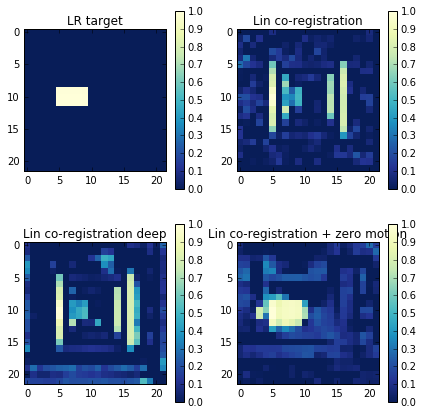

In [921]:
plt.figure(figsize=(7,7))

time_series = np.hstack((lr_vols[-100:,...][:,10,5,5][:,np.newaxis],lr_vols[-100:,...,5].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data.shape[1],test_data.shape[2]))
plt.subplot(2,2,1)
plt.title('LR target')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

time_series = np.hstack((lr_vols_motion_cor[-100:,...][:,10,5,5][:,np.newaxis],lr_vols_motion_cor[-100:,...,5].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data.shape[1],test_data.shape[2]))
plt.subplot(2,2,2)
plt.title('Lin co-registration')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()


time_series = np.hstack((test_data[:,10,5,0][:,np.newaxis],test_data[:,:,:,0].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data.shape[1],test_data.shape[2]))
plt.subplot(2,2,3)
plt.title('Lin co-registration deep')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

time_series = np.hstack((test_data_zerom[:,10,5,0][:,np.newaxis],test_data_zerom[:,:,:,0].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data_zerom.shape[1],test_data_zerom.shape[2]))
plt.subplot(2,2,4)
plt.title('Lin co-registration + zero motion')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()


#lr_vols_motion_cor[-100:,...,5]

In [709]:
mask_roi = lr_vols.std(0)!=0
mask_roi_2d = np.swapaxes(mask_roi[...,5],0,-1)

time_series = np.swapaxes(lr_vols_motion_cor[-100:,...,5],0,-1)[mask_roi_2d].mean(0)
time_series.shape

(100,)

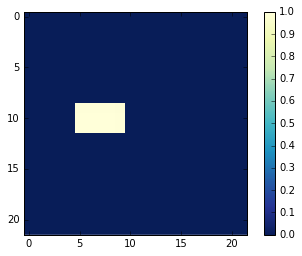

In [723]:
plt.imshow(cor_map_ref!=0,cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

In [730]:
(cor_map_ref!=0).shape

(22, 22)

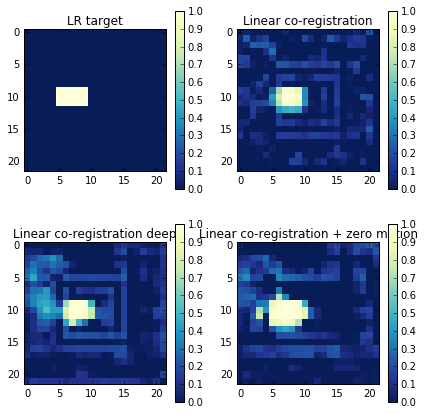

In [922]:
plt.figure(figsize=(7,7))

mask_roi_2d = np.swapaxes(cor_map_ref!=0,0,-1)

time_series = np.hstack((np.swapaxes(lr_vols[-100:,...,5],0,-1)[mask_roi_2d].mean(0)[:,np.newaxis],lr_vols[-100:,...,5].reshape((100,22*22)))).T
#time_series = np.hstack((lr_vols[-100:,...][:,10,5,5][:,np.newaxis],lr_vols[-100:,...,5].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data.shape[1],test_data.shape[2]))
plt.subplot(2,2,1)
plt.title('LR target')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

time_series = np.hstack((np.swapaxes(lr_vols_motion_cor[-100:,...,5],0,-1)[mask_roi_2d].mean(0)[:,np.newaxis],lr_vols_motion_cor[-100:,...,5].reshape((100,22*22)))).T
#time_series = np.hstack((lr_vols_motion_cor[-100:,...][:,10,5,5][:,np.newaxis],lr_vols_motion_cor[-100:,...,5].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data.shape[1],test_data.shape[2]))
plt.subplot(2,2,2)
plt.title('Linear co-registration')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

time_series = np.hstack((np.swapaxes(test_data[...,0],0,-1)[mask_roi_2d].mean(0)[:,np.newaxis],test_data[:,:,:,0].reshape((100,22*22)))).T
#time_series = np.hstack((test_data[:,10,5,0][:,np.newaxis],test_data[:,:,:,0].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data.shape[1],test_data.shape[2]))
plt.subplot(2,2,3)
plt.title('Linear co-registration deep')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

time_series = np.hstack((np.swapaxes(test_data_zerom[...,0],0,-1)[mask_roi_2d].mean(0)[:,np.newaxis],test_data_zerom[:,:,:,0].reshape((100,22*22)))).T
#time_series = np.hstack((test_data_zerom[:,10,5,0][:,np.newaxis],test_data_zerom[:,:,:,0].reshape((100,22*22)))).T
coor_map_ = np.corrcoef(time_series)[0,1:].reshape((test_data_zerom.shape[1],test_data_zerom.shape[2]))
plt.subplot(2,2,4)
plt.title('Linear co-registration + zero motion')
plt.imshow(np.nan_to_num(coor_map_),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()


#lr_vols_motion_cor[-100:,...,5]

In [733]:
test_data_zerom.shape

(100, 22, 22, 1)

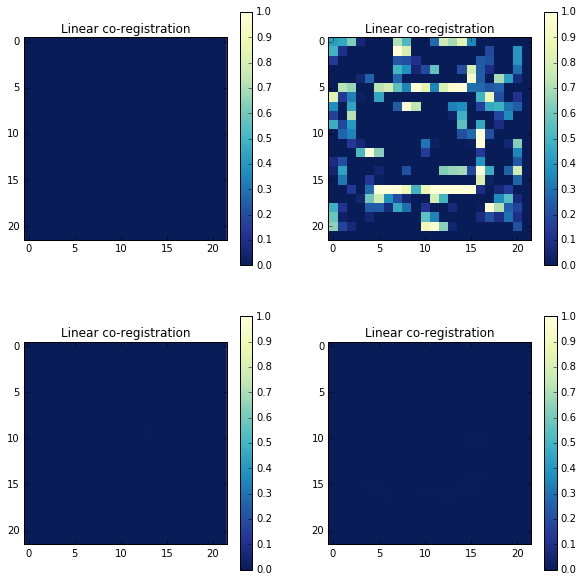

In [869]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Linear co-registration')
plt.imshow(np.nan_to_num(lr_vols[-100,:,:,5]-lr_vols[-100:,...,5].mean(0)),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()
plt.subplot(2,2,2)
plt.title('Linear co-registration')
plt.imshow(np.nan_to_num(lr_vols_motion_cor[-100,:,:,5]-lr_vols_motion_cor[-100:,...,5].mean(0)),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

plt.subplot(2,2,3)
plt.title('Linear co-registration')
plt.imshow(np.nan_to_num(test_data[0,:,:,0]-test_data[:,...,0].mean(0)),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

plt.subplot(2,2,4)
plt.title('Linear co-registration')
plt.imshow(np.nan_to_num(test_data_zerom[0,:,:,0]-test_data_zerom[:,...,0].mean(0)),cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1,interpolation='none')
plt.colorbar()

In [545]:
test_data.shape

(100, 22, 22, 1)

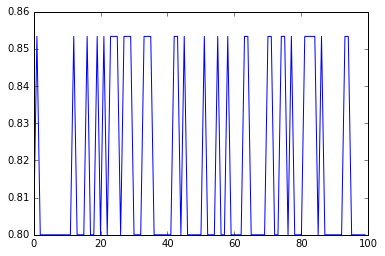

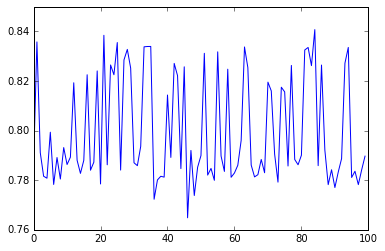

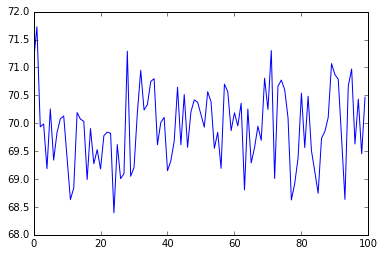

In [637]:
plt.figure()
plt.plot(test_target[:,9,7,0][:100])
plt.figure()
plt.plot(test_data[:,9,7,0][:100])
plt.figure()
plt.plot(lr_vols_motion_cor[:,9,7,0][-100:])

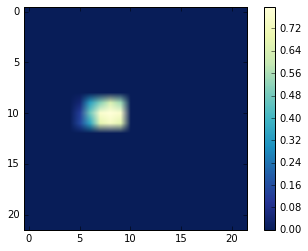

In [352]:
plt.imshow(np.nan_to_num(cor_map),cmap=plt.get_cmap('YlGnBu_r'))
plt.colorbar()

In [384]:
v2w_lr[[0,1,3],:][:,[0,1,3]]

array([[  3.,   0., -31.],
       [  0.,   3., -31.],
       [  0.,   0.,   1.]])

In [396]:
aa = np.zeros_like(lr_vols_motion[-100:,:,:,:])
aa[...,5] = test_data[...,0]

test_corrected_coreg = []
for i in range(aa.shape[0]):
    coreg_vol, transf = registration.transform(aa[i,...],motion_params[-100+i,:],v2w_lr,inv_affine=True)
    test_corrected_coreg.append(coreg_vol)
test_corrected_coreg = np.stack(test_corrected_coreg)

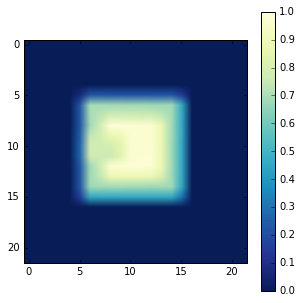

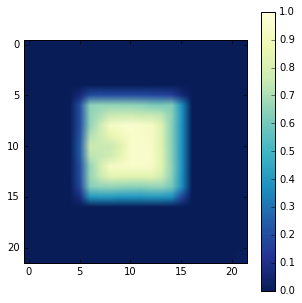

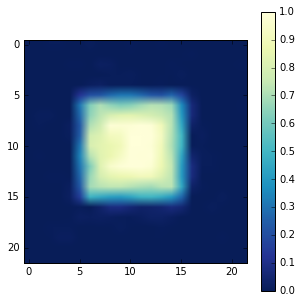

In [638]:
test_data = vae.predict([lr_vols_motion_cor[-100:,:,:,5,np.newaxis].copy()/100.,test_motion],batch_size=1)
plt.figure(figsize=(5,5))
plt.imshow(test_data[10,...,0],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1)
plt.colorbar()

test_data = vae.predict([lr_vols_motion_cor[-100:,:,:,5,np.newaxis].copy()/100.,np.zeros_like(test_motion)],batch_size=1)

plt.figure(figsize=(5,5))
plt.imshow(test_data[10,...,0],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1)
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(test_corrected_coreg[10,...,5],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1)
plt.colorbar()

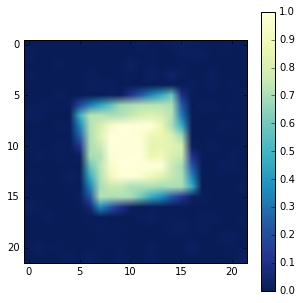

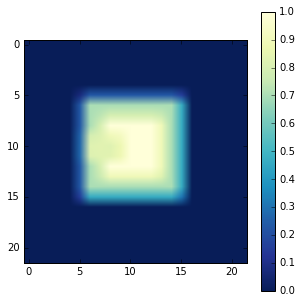

In [359]:

plt.figure(figsize=(5,5))
plt.imshow(test_data[10,...,0],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1)
plt.colorbar()

plt.figure(figsize=(5,5))
plt.imshow(test_target[10,...,0],cmap=plt.get_cmap('YlGnBu_r'),vmin=0,vmax=1)
plt.colorbar()

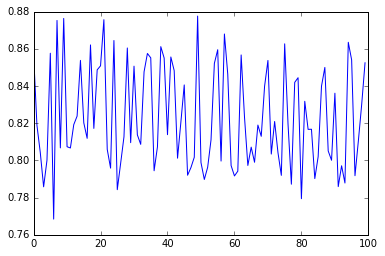

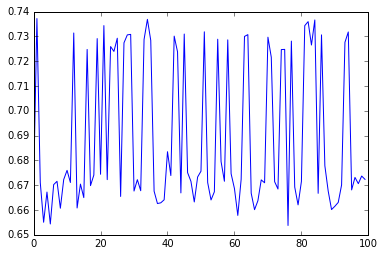

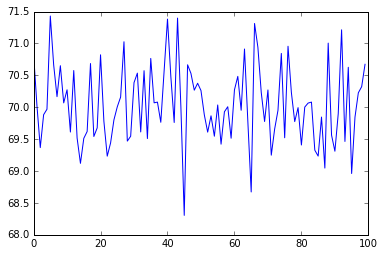

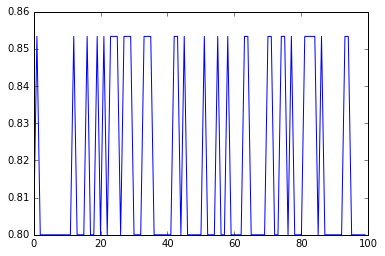

In [602]:
plt.figure()
plt.plot(y_augm[:,9,7,0][:100])

plt.figure()
plt.plot(test_data[:,9,7,0][:100])

plt.figure()
plt.plot(lr_vols_motion_cor[:,9,7,0][:100])

plt.figure()
plt.plot(test_target[:,9,7,0][:100])

In [657]:
import numpy.linalg as npl
reload(registration)
aa =registration.aff_tsf(1,2,3,0.3,0.1,0.9)

print aa
print npl.inv(aa)

b = registration.aff_tsf(1,2,3,0,0,0)
M = registration.aff_tsf(0,0,0,0.3,0.1,0.9)

-npl.inv(M)[:3,:3].dot(b[:3,3])
npl.inv(M)

print registration.aff_tsf(1,2,3,0.3,0.1,0.9,inv_affine=True)

[[ 0.61850451 -0.77941354  0.09983342  1.        ]
 [ 0.76668001  0.57073635 -0.29404384  2.        ]
 [ 0.17220319  0.25840772  0.95056379  3.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.61850451  0.76668001  0.17220319 -2.66847409]
 [-0.77941354  0.57073635  0.25840772 -1.13728234]
 [ 0.09983342 -0.29404384  0.95056379 -2.3634371 ]
 [ 0.          0.          0.          1.        ]]
[[ 0.61850451  0.76668001  0.17220319 -2.66847409]
 [-0.77941354  0.57073635  0.25840772 -1.13728234]
 [ 0.09983342 -0.29404384  0.95056379 -2.3634371 ]
 [ 0.          0.          0.          1.        ]]


In [675]:
np.corrcoef([y_target[:,9,7,0],test_data[:,9,7,0],lr_vols_motion_cor[:,9,7,0],y_augm[:,9,7,0],y_augm[:,9,7,0]-test_data[:,9,7,0]])

array([[ 1.        ,  0.91929327,  0.04280233,  0.26841613, -0.11705951],
       [ 0.91929327,  1.        ,  0.11654502,  0.31621955, -0.10191982],
       [ 0.04280233,  0.11654502,  1.        ,  0.37932297,  0.34723506],
       [ 0.26841613,  0.31621955,  0.37932297,  1.        ,  0.91151683],
       [-0.11705951, -0.10191982,  0.34723506,  0.91151683,  1.        ]])